## Eleventh Session of Stochastic Modelling

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guglielmopadula/StochasticModelling2022-2023/blob/main/TwelveSession.ipynb)


## Introduction of Bayesian Inference and Pyro

In bayesian inference we are given a likehood
$p(y_{1},...,y_{n}|\theta)$ and a prior $p(\theta)$, which represents out actual knowledge around $\theta$ and we want to estimate $$\theta_{MAP}=\arg \max_{\theta} p(\theta|y)∝ p(y|\theta)p(\theta)$$

For a markov process we have
$p(y_{n}|y_{n-1}\theta)*p(y_{n-1}|y_{n-2}\theta)...*p(y_{2}|y_{1}\theta)*p(y_{1}|\theta)p(\theta)$
If we want to sample, the smartest thing to do is:
- sample $\theta$ from $p(\theta)$
- sample $y_{1}$ from $p(y_{1}|\theta)$.
- sample $y_{2}$ from $p(y_{2}|\theta,y_{1})$.
- ....
- sample $y_{n}$ from $p(y_{n}|\theta,y_{n-2})$

###DTMC
$\theta$ is our $m \times m$ transition matrix. 
We have that $$p(y_{n}|y_{n-1},\theta)=\theta_{y_{n-1},y_{n}}$$
We need a prior that samples a probability. This prior is called Dirichlet and it's parameters are $\alpha_{1}>1,...,\alpha_{m}>1$, this distribution is highly technical and we will not see it.
The lower the parameter prior are, the more the prior is uninformative and the more the MAP will be similar to the MLE.

###CTMC
A CTMC parametrized by a $m \times m$ transition matrix $\theta$  and a $m$ vector $\lambda$  can be seen as a sequence of tuples $(t_{1},Y_{t_{1}}),(t_{2},Y_{t_{2}})$ where $Y_{t_{i}}=X_{i}$ and $X_{n}$ is a DTMC with matrix $\theta$ and $t_{n+1}-t_{n}\sim Exp({\lambda_{X_{n}}})$.
We need a prior for $\theta$, for which we use a Dirichlet again, but also a prior for $\lambda$, which must have a positive support, for reasons that go beyond the scope of this course, a Gamma distribution with parameters $\alpha,\beta$ is a good choice.

### SDE
We saw that an sde can be approximated with
$$X_{n+1}=f(X_{n},t_{n},\theta)+g(X_{n},t_{n},\theta)\epsilon$$, where $$\epsilon \sim Normal(0,1)$$, 
so $$X_{n+1}\sim Normal(X{t}+f(X_{n},t_{n},\theta)*\Delta t,g(X_{n},t_{n},\theta)^{2})$$

A library for computing $\theta_{MAP}$ (an not only that) given the sequence of samples to do is called numpyro, which is based on JAX.

In [4]:
!pip install pyro-ppl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 17.7 MB/s eta 0:00:00


## DTMC


### Maximum likehood estimation

100%|██████████| 100/100 [00:52<00:00,  1.90it/s]

MLE VALUES ARE
tensor([[0.5582, 0.1441, 0.2977],
        [0.4745, 0.3131, 0.2124],
        [0.7728, 0.1169, 0.1104]])
REAL VALUES ARE [[0.56127324 0.12731909 0.31140767]
 [0.44062379 0.36721539 0.19216082]
 [0.78867472 0.12564263 0.08568266]]


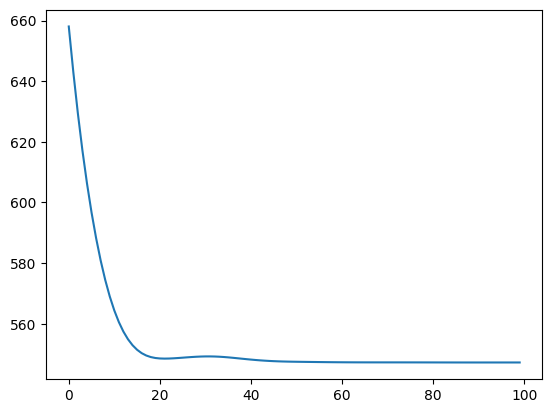

In [5]:
import numpy as np
import pyro.optim as optim
import torch
from tqdm import trange
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro import sample
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
import pyro
import matplotlib.pyplot as plt
def model(samples):
    m=torch.max(samples)+1
    with pyro.plate("num_states",m): #this mean sample everything m times
      theta=sample("theta", dist.Dirichlet(torch.ones(m)).mask(False)) ### .mask(FALSE) for MLE
      ## because we are in a plate of size m, theta will be of shape (m,m)
    x0=samples[0]
    tmp_old=x0
    for i in range(1,len(samples)):
      prob=theta[tmp_old]
      tmp=sample("obs_{}".format(i), dist.Categorical(prob), obs=samples[i])
      tmp_old=tmp
def DtmcSimulation(A,p0,n):
    if not np.prod(A>=0):
        raise Exception("Elements are not non negative")
    if not np.prod(np.isclose(np.sum(A,axis=1),np.ones(A.shape[0]))):
        raise Exception("at least one row does not sum up to 1")
    if not np.isclose(np.sum(p0),1):
        raise Exception("initial probability does not sum up to 1")

    l=[]
    x0=np.random.choice(np.arange(p0.shape[0]),size=1,p=p0)
    l.append(x0.item())
    x=x0
    for i in range(1,n):
        p=A[x].reshape(-1)
        x=np.random.choice(np.arange(p.shape[0]),size=1,p=p)
        l.append(x.item())
    return l,A,p0

np.random.seed(0)
torch.manual_seed(0)
A=np.abs(np.random.normal(size=(3,3)))
A=(A.T/np.sum(A.T,axis=0)).T
p0=np.array([1/3,1/3,1/3])
values=DtmcSimulation(A,p0,600)[0]
values=torch.tensor(values)

m=torch.max(values)+1
guide=AutoDelta(model)
adam_params = {"lr": 0.05, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, Trace_ELBO())
loss=[]
for i in trange(100):
  loss.append(svi.step(values))

print("MLE VALUES ARE")
print(guide.median(values)["theta"])


print("REAL VALUES ARE", A)
plt.plot(np.arange(len(loss)),loss)



Note that the MLE and our real parameter are pretty similar, better results can be achieved with more iterations.

### Weak prior

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]

Weak MAP VALUES ARE
tensor([[0.5590, 0.1433, 0.2978],
        [0.4748, 0.3131, 0.2121],
        [0.7708, 0.1181, 0.1111]])
REAL VALUES ARE [[0.56127324 0.12731909 0.31140767]
 [0.44062379 0.36721539 0.19216082]
 [0.78867472 0.12564263 0.08568266]]


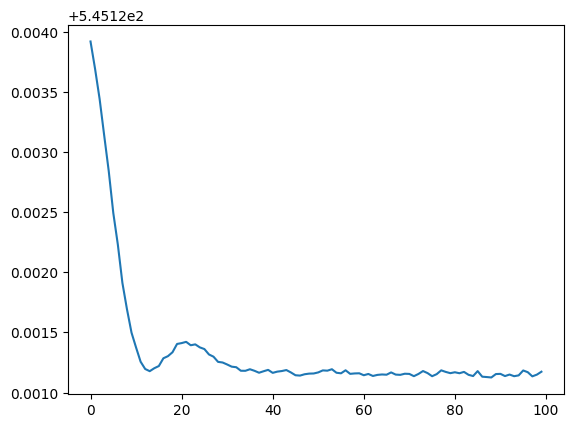

In [6]:
def model(samples):
    m=torch.max(samples)+1
    with pyro.plate("num_states",m): #this mean sample everything m times
      theta=sample("theta", dist.Dirichlet(1*torch.ones(m))) ### very weak prior
      ## because we are in a plate of size m, theta will be of shape (m,m)
    x0=samples[0]
    tmp_old=x0
    for i in range(1,len(samples)):
      prob=theta[tmp_old]
      tmp=sample("obs_{}".format(i), dist.Categorical(prob), obs=samples[i])
      tmp_old=tmp
def DtmcSimulation(A,p0,n):
    if not np.prod(A>=0):
        raise Exception("Elements are not non negative")
    if not np.prod(np.isclose(np.sum(A,axis=1),np.ones(A.shape[0]))):
        raise Exception("at least one row does not sum up to 1")
    if not np.isclose(np.sum(p0),1):
        raise Exception("initial probability does not sum up to 1")

    l=[]
    x0=np.random.choice(np.arange(p0.shape[0]),size=1,p=p0)
    l.append(x0.item())
    x=x0
    for i in range(1,n):
        p=A[x].reshape(-1)
        x=np.random.choice(np.arange(p.shape[0]),size=1,p=p)
        l.append(x.item())
    return l,A,p0

guide=AutoDelta(model)
svi = SVI(model, guide, optimizer, Trace_ELBO())
loss=[]
for i in trange(100):
  loss.append(svi.step(values))

print("Weak MAP VALUES ARE")
print(guide.median(values)["theta"])


print("REAL VALUES ARE", A)
plt.plot(np.arange(len(loss)),loss)



Again the results are very similar to the real value.

### Strong prior

100%|██████████| 100/100 [00:35<00:00,  2.83it/s]

Strong MAP VALUES ARE
tensor([[0.3363, 0.3308, 0.3328],
        [0.3345, 0.3331, 0.3324],
        [0.3370, 0.3317, 0.3313]])
REAL VALUES ARE [[0.56127324 0.12731909 0.31140767]
 [0.44062379 0.36721539 0.19216082]
 [0.78867472 0.12564263 0.08568266]]


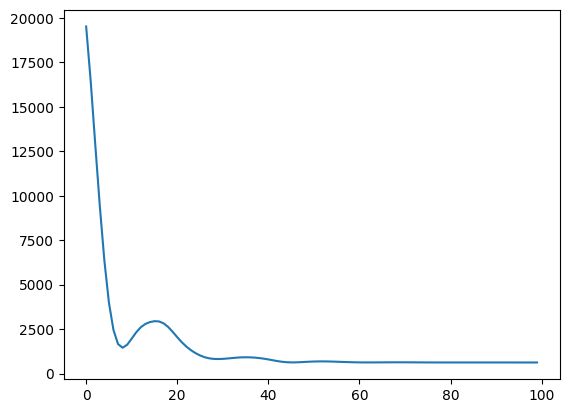

In [7]:
def model(samples):
    m=torch.max(samples)+1
    with pyro.plate("num_states",m): #this mean sample everything m times
      theta=sample("theta", dist.Dirichlet(9999*torch.ones(m))) ### very strong prior
      ## because we are in a plate of size m, theta will be of shape (m,m)
    x0=samples[0]
    tmp_old=x0
    for i in range(1,len(samples)):
      prob=theta[tmp_old]
      tmp=sample("obs_{}".format(i), dist.Categorical(prob), obs=samples[i])
      tmp_old=tmp
def DtmcSimulation(A,p0,n):
    if not np.prod(A>=0):
        raise Exception("Elements are not non negative")
    if not np.prod(np.isclose(np.sum(A,axis=1),np.ones(A.shape[0]))):
        raise Exception("at least one row does not sum up to 1")
    if not np.isclose(np.sum(p0),1):
        raise Exception("initial probability does not sum up to 1")

    l=[]
    x0=np.random.choice(np.arange(p0.shape[0]),size=1,p=p0)
    l.append(x0.item())
    x=x0
    for i in range(1,n):
        p=A[x].reshape(-1)
        x=np.random.choice(np.arange(p.shape[0]),size=1,p=p)
        l.append(x.item())
    return l,A,p0

guide=AutoDelta(model)
svi = SVI(model, guide, optimizer, Trace_ELBO())
loss=[]
for i in trange(100):
  loss.append(svi.step(values))

print("Strong MAP VALUES ARE")
print(guide.median(values)["theta"])


print("REAL VALUES ARE", A)
plt.plot(np.arange(len(loss)),loss)



Now you see that the MAP is really far from the real value, because the prior it too strong and so the data in not considered.

## CTMC


100%|██████████| 500/500 [05:07<00:00,  1.63it/s]

Weak MAP VALUES ARE
tensor([[0.5488, 0.0954, 0.3558],
        [0.4900, 0.3020, 0.2079],
        [0.6513, 0.1919, 0.1569]])
tensor([1.9420, 0.8249, 2.8888])
REAL VALUES ARE [[0.56127324 0.12731909 0.31140767]
 [0.44062379 0.36721539 0.19216082]
 [0.78867472 0.12564263 0.08568266]] [2 1 3]


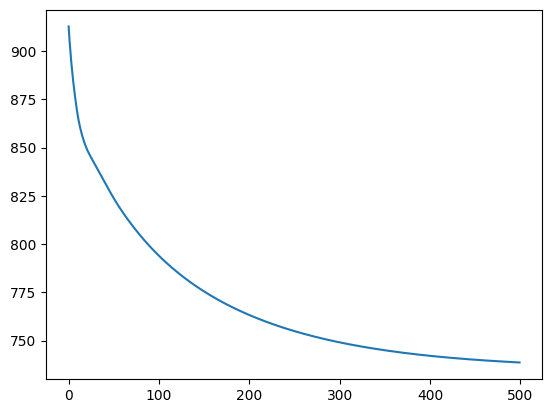

In [8]:
import scipy
def CtmcSimulation(A,rates,x0,n):
  times=[]
  states=[]
  x=x0
  tot_time=0
  times.append(0)
  states.append(x)
  for i in range(1,n):
    t=scipy.stats.expon(scale=1/rates[x0]).rvs(size=1)[0]
    tot_time=tot_time+t
    x=np.random.choice(len(A),p=A[x])
    times.append(tot_time)
    states.append(x)
    x0=x
  return times,states

rates=np.array([2,1,3])
t,x=CtmcSimulation(A,np.array([2,1,3]),0,600)
t=torch.tensor(t)
x=torch.tensor(x)
def model(t,x):
    m=torch.max(x)+1
    with pyro.plate("num_states_theta",m): #this mean sample everything m times
      theta=sample("theta", dist.Dirichlet(1*torch.ones(m))) ### very strong prior
    with pyro.plate("num_states_rates",m):
      rates=sample("rates", dist.Gamma(2,1))
    tmp_old=x[0]
    

    for i in range(1,len(x)):
      prob=theta[tmp_old]
      rate=rates[tmp_old]
      tmp=sample("x_{}".format(i), dist.Categorical(prob), obs=x[i])
      deltat=sample("t_{}".format(i), dist.Exponential(rate), obs=t[i]-t[i-1])
      tmp_old=tmp
    

guide=AutoDelta(model)
svi = SVI(model, guide, optimizer, Trace_ELBO())
loss=[]
for i in trange(500):
  loss.append(svi.step(t,x))

print("Weak MAP VALUES ARE")
print(guide.median(values)["theta"])
print(guide.median(values)["rates"])


print("REAL VALUES ARE", A, rates)
plt.plot(np.arange(len(loss)),loss)



### Euler maruyama

In [9]:
def euler_maruyama(a,b,x0,t0,tf,n,m):
    t=tf-t0
    tpoints=np.linspace(0,t,n)
    deltat=tpoints[1]-tpoints[0]
    x=np.zeros((n,x0.reshape(-1).shape[0],m))
    x[0]=np.tile(x0.reshape(1,x0.shape[0],1),(1,1,m))
    for i in range(1,n):
        x[i]=x[i-1]+a(x[i-1],tpoints[i-1])*deltat+b(x[i-1],tpoints[i-1])*np.random.randn(*x[0].shape)*np.sqrt(deltat)
    return tpoints,x


a=lambda x,t: 5*x
b=lambda x,t: 2*np.exp(-x**2)

t0=0
tf=30
x0=np.array([0])
n=500
m=1
t,x=euler_maruyama(a,b,x0,t0,tf,n,m)

def a_torch(x,mu):
  return 0.5*x

def b_torch(x,sigma):
  return 0.5*torch.exp(-x**2)




t=torch.tensor(t)
x=torch.tensor(x).reshape(-1)
deltat=t[1]-t[0]

def model(x,deltat):
    xold=x[0]
    mu=sample("mu", dist.Normal(0,1))
    sigma=sample("sigma",dist.Gamma(1,1))
    for i in range(1,len(x)):
      _=sample("x_{}".format(i), dist.Normal(xold+a_torch(xold,mu)*deltat,b_torch(xold,sigma)*torch.sqrt(deltat)), obs=x[i])

print(x.shape)
guide=AutoDelta(model)
svi = SVI(model, guide, optimizer, Trace_ELBO())
loss=[]
for i in trange(500):
  loss.append(svi.step(x,deltat))

print("Weak MAP VALUES ARE")
print(guide.median(values)["mu"])
print(guide.median(values)["sigma"])
plt.plot(np.arange(len(loss)),loss)




torch.Size([500])


  0%|          | 1/500 [00:00<02:51,  2.91it/s]


ValueError: ignored